# Import modul dan dataset

In [1]:
!pip install python_speech_features
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from pydub import AudioSegment
from python_speech_features import mfcc
from time import time

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=e815ad53f533279420740e98b82a373d497a490227b06697b6dc293170c7e1f2
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
df = pd.read_csv('../input/common-voice/cv-valid-train.csv')
print(df.shape)
df[['filename', 'gender']].head()

(195776, 8)


,filename,gender
0,cv-valid-train/sample-000000.mp3,NaN
1,cv-valid-train/sample-000001.mp3,NaN
2,cv-valid-train/sample-000002.mp3,NaN
3,cv-valid-train/sample-000003.mp3,NaN
4,cv-valid-train/sample-000004.mp3,NaN


In [3]:
print(df['gender'].value_counts())
print("Jumlah data yang berlabel:", df['gender'].value_counts().sum())

male      55029
female    18249
other       781
Name: gender, dtype: int64
Jumlah data yang berlabel: 74059


# Ambil data 150 male dan 150 female

In [4]:
df_male = df[df['gender']=='male'][:150]
df_female = df[df['gender']=='female'][:150]

In [5]:
print(df_male.shape)
print(df_female.shape)

(150, 8)
(150, 8)


# Convert 300 data ini jadi wav

In [6]:
TRAIN_PATH = '../input/common-voice/cv-valid-train/'

def convert_to_wav(df, m_f, path=TRAIN_PATH):
    for file in tqdm(df['filename']):
        sound = AudioSegment.from_mp3(path+file)
        if m_f == 'male':
            sound.export('male-'+file.split('/')[-1].split('.')[0]+'.wav', format='wav')
        elif m_f == 'female':
            sound.export('female-'+file.split('/')[-1].split('.')[0]+'.wav', format='wav')
        
    return

In [7]:
convert_to_wav(df_male, m_f='male')
convert_to_wav(df_female, m_f='female')

100%|██████████| 150/150 [00:08<00:00, 17.14it/s]


In [8]:
len(os.listdir())

301

# Load audio yang udah jadi wav tadi
# Masing-masing file akan jadi array berdimensi 1

In [9]:
def load_audio(audio_files):
    male_voices = []
    female_voices = []

    for file in tqdm(audio_files):
        
        if file == '__notebook_source__.ipynb':
            continue
        else:
            wave, samplerate = librosa.load(file)
            
        if file.split('-')[0] == 'male':
            male_voices.append(wave)
        elif file.split('-')[0] == 'female':
            female_voices.append(wave)
            
    male_voices = np.array(male_voices)
    female_voices = np.array(female_voices)
    
    return male_voices, female_voices

In [10]:
male_voices, female_voices = load_audio(os.listdir())

100%|██████████| 301/301 [00:57<00:00,  5.24it/s]


# Audio feature extraction

In [11]:
def extract_features(audio_data):
    features = []
    for audio_wave in tqdm(audio_data):
        features.append(mfcc(audio_wave, samplerate=22050, 
                             numcep=20, winstep=0.01, winlen=0.025))
    
    features = np.array(features)
    return features

In [12]:
male_features = extract_features(male_voices)
female_features = extract_features(female_voices)

100%|██████████| 150/150 [00:01<00:00, 93.90it/s]


# Audio mentah vs MFCC features (female ke-6). Ini untuk menampilkan ilustrasi aja

Length in bits		: 30000
Length in seconds	: 1.3605442176870748


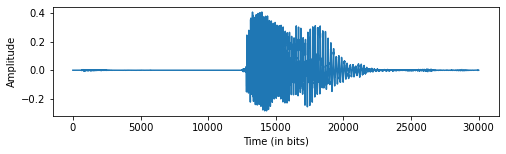

In [13]:
# Ambil salah satu sampel sebagai contoh
example = female_voices[5][:30000]

print('Length in bits\t\t:', len(example))
print('Length in seconds\t:', len(example)/22050)
plt.figure(figsize=(8,2))
plt.plot(example)
plt.xlabel('Time (in bits)')
plt.ylabel('Amplitude')
plt.show()

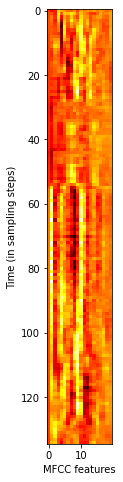

In [14]:
example_features = mfcc(example, samplerate=22050, 
                        numcep=20, winstep=0.01, winlen=0.025)
plt.figure(figsize=(6,8))
plt.imshow(example_features, cmap='hot')
plt.xlabel('MFCC features')
plt.ylabel('Time (in sampling steps)')
plt.show()

# Gabungin semua featuresnya

In [15]:
print(male_features[0].shape)
print(male_features[1].shape)
print(male_features[2].shape)

(274, 20)
(349, 20)
(408, 20)


In [16]:
def concatenate_features(audio_features):
    concatenated = audio_features[0]
    for audio_feature in tqdm(audio_features):
        concatenated = np.vstack((concatenated, audio_feature))
        
    return concatenated

In [17]:
male_concatenated = concatenate_features(male_features)
female_concatenated = concatenate_features(female_features)

print(male_concatenated.shape)
print(female_concatenated.shape)

100%|██████████| 150/150 [00:00<00:00, 1167.82it/s]

(58265, 20)
(64221, 20)


In [18]:
X = np.vstack((male_concatenated, female_concatenated))
X.shape

(122486, 20)

# Buat label

In [19]:
y = np.append([0] * len(male_concatenated), [1] * len(female_concatenated))
y.shape

(122486,)

# Train test split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
print(y_train[:20])

[1 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0]


In [21]:
print(X_train.shape)
print(X_test.shape)

(97988, 20)
(24498, 20)


# Inisialisasi model SVM

In [22]:
clf = SVC(kernel='rbf')

In [23]:
start = time()
clf.fit(X_train, y_train)
print(time()-start)

554.1147315502167


In [24]:
start = time()
print(clf.score(X_train, y_train))
print(time()-start)

0.8069049271339348
271.87793135643005


In [25]:
start = time()
print(clf.score(X_test, y_test))
print(time()-start)

0.7889623642746346
68.08400130271912


# Model evaluation

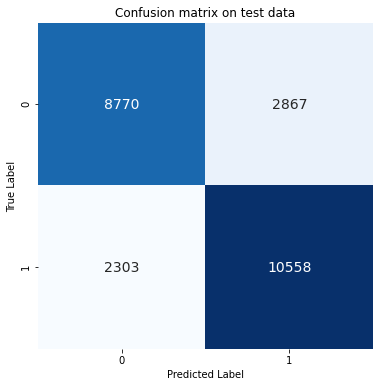

In [42]:
# Memprediksi data test dulu
predictions = clf.predict(X_test)

# Bandingkan dengan labelnya
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(6,6))
plt.title('Confusion matrix on test data')
sns.heatmap(cm, annot=True, fmt='d', 
            cmap=plt.cm.Blues, cbar=False, annot_kws={'size':14})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [62]:
TEST_FILE = './female-sample-000124.wav'

def predict_test(file):
    wave, samplerate = librosa.load(file)
    wave_features = mfcc(wave, samplerate=22050, 
                         numcep=20, winstep=0.01, winlen=0.025)
    return clf.predict(wave_features)

In [63]:
test_prediction = predict_test(TEST_FILE)
test_prediction

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,

In [64]:
def calculate_probability(prediction_result):
    # Jumlah prediksi 0 (male)
    male_preds = np.unique(test_prediction, return_counts=True)[1][0]
    
    # Jumlah prediksi 1 (female)
    female_preds = np.unique(test_prediction, return_counts=True)[1][1]
    
    # Hitung probabilitas kedua class
    male_probability = male_preds/(male_preds+female_preds)
    female_probability = female_preds/(male_preds+female_preds)
    
    return male_probability, female_probability

In [65]:
calculate_probability(test_prediction)

(0.125, 0.875)